Need to go through each "slice" fastq file and create a file containing, for each line, filepath and the reference sequence for that slice.

In [108]:
import glob
import os
import pysam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
fpaths = glob.glob('../slice_fastq_files/padding_10/*.fastq')
ref = pysam.FastaFile('../mccortex_graphs/ecoli_ref/NC_000913.3.fa')
ref_name = ref.references[0]
outpath = '../slice_fastq_files/padding_10/ref_seqs_for_slices_padding_10.tsv'

In [83]:
def extract_range(string):
    return tuple(int(x) for x in string.split('_')[-1].replace('.fastq', '').split('-'))

In [84]:
# with open(outpath, 'w') as fout:
#     for fp in fpaths:
#         p = os.path.abspath(fp.path)
#         if not p.endswith('.fastq'):
#             continue
#         start, end = extract_range(p)
#         ref_seq = ref.fetch(ref_name, start, end)
#         print(f"{p}\t{ref_seq}", file=fout)

After generating paths for the slices need to first figure out how many slices *didn't* get created and then of the ones that did, how many contain the reference path?

In [92]:
df = pd.read_csv(outpath, sep='\t', header=None)
df.columns = ["filepath", "ref_sequence"]
df['path_exists'] = False
df['local_assembly'] = False
df['basename'] = df.filepath.apply(lambda f: os.path.basename(f).replace('.fastq', ''))

In [86]:
paths_dir = os.path.abspath('../slice_fastq_files/padding_10/local_assembly_paths/')
path_filepaths = glob.glob(paths_dir + '/*.fa')

In [87]:
print(len(path_filepaths))
print(len(df.filepath))

1628
2853


In [96]:
for fpath in path_filepaths:
    name = os.path.basename(fpath).split('_K')[0]
    idx = df.index[df['basename'] == name]
    df.loc[idx, 'local_assembly'] = True
    ref = df.loc[idx, 'ref_sequence'].iloc[0]
    with pysam.FastxFile(fpath) as fasta:
        for record in fasta:
            if record.sequence == ref:
                df.loc[idx, 'path_exists'] = True
                break

In [98]:
worked = df[df['path_exists'] == True]

In [101]:
num_paths = []
for fpath in worked.filepath:
    count = 0
    with pysam.FastxFile(fpath) as fh:
        for record in fh:
            count += 1
    num_paths.append(count)

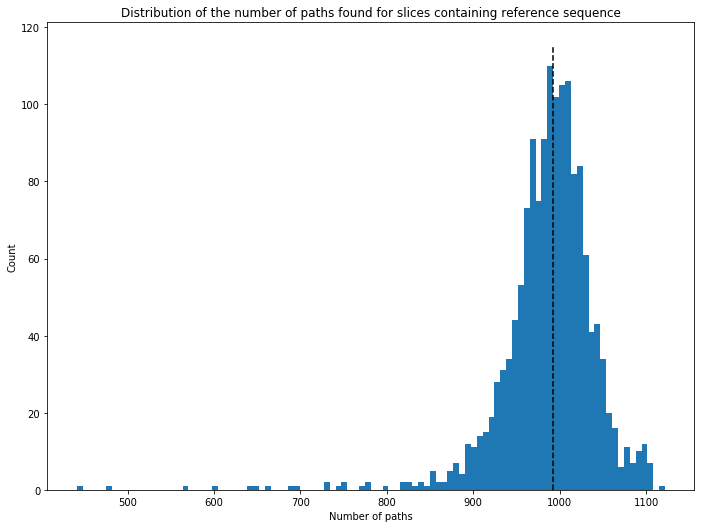

In [130]:
median = np.median(num_paths)
fig, ax = plt.subplots(figsize=(11.6,8.6))
ax.hist(num_paths, bins=100)
ymin, ymax = ax.get_ylim()
ax.vlines(median, ymin, ymax, linestyles='dashed')
_ = ax.set_xlabel('Number of paths')
_ = ax.set_ylabel('Count')
_ = ax.set_title('Distribution of the number of paths found for slices containing reference sequence')

In [139]:
no_ref_path = df[df['path_exists'] == False]
no_ref_path = no_ref_path[no_ref_path['local_assembly'] == True]

In [140]:
num_paths = []
for fpath in no_ref_path.filepath:
    count = 0
    with pysam.FastxFile(fpath) as fh:
        for record in fh:
            count += 1
    num_paths.append(count)

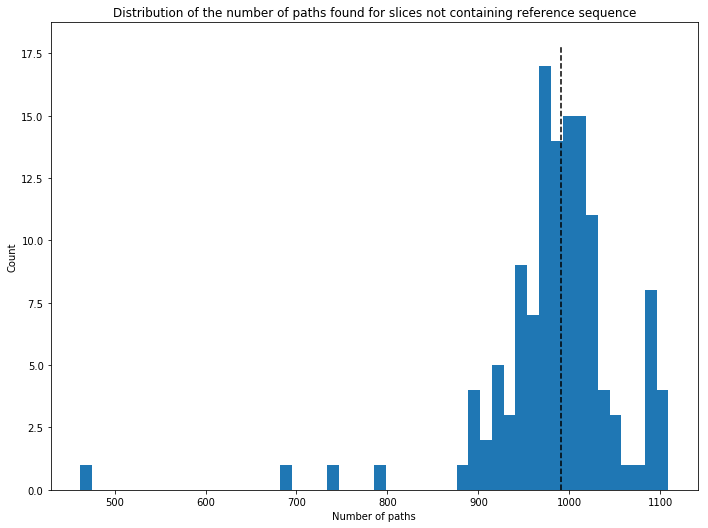

In [142]:
median = np.median(num_paths)
fig, ax = plt.subplots(figsize=(11.6,8.6))
ax.hist(num_paths, bins=50)
ymin, ymax = ax.get_ylim()
ax.vlines(median, ymin, ymax, linestyles='dashed')
_ = ax.set_xlabel('Number of paths')
_ = ax.set_ylabel('Count')
_ = ax.set_title('Distribution of the number of paths found for slices not containing reference sequence')